
# Kernelized Nearest Mean Classifier on the Spam Mail Detection


### Implementation of Nearest_Mean Classifier
Given training data $\{(x_i, y_i)\}$ and kernel $k$, let $C_i = \{ j:y_j =1 \}$, the empirical mean element of class $i$ in RKHS is defined as
$ \mu_i = \frac{1}{|C_i|}\sum_{j \in C_i} k( x_j, \cdot ) $
For a new data $x$, the nearest mean classifier predicts the label of $x$ using
$$
\begin{align*}
\hat{y} 
& = \arg \min_{i}\quad || k(x, \cdot) - \mu_i ||^2_{\cal{H}} \\
& = \arg \max_{i}\quad \langle  k(x,\cdot), \mu_i \rangle_{\mathcal{H}} - 0.5 ||\mu_i ||^2_{\cal{H}} \\
& = \arg \max_{i}\quad \frac{1}{|C_i|}\sum_{j \in C_i} k( x_j, x ) 
- 0.5 \frac{1}{|C_i|^2}\sum_{a,b \in C_i} k( a, b ) \\
& = \arg \max_{i}\quad \mathrm{score}(x,i) 
&& \mathrm{score}(x,i):= \frac{1}{|C_i|}\sum_{j \in C_i} k( x_j, x ) 
- 0.5 \frac{1}{|C_i|^2}\sum_{a,b \in C_i} k( a, b )
\end{align*}
$$

So, large score(x, i) means $x$ is close to the empirical mean element of class $i$ in the RKHS.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# nearest_mean classifier
class Nearest_Mean():
    
    def __init__(self):
        return
        
        
    def train(self, X, y, kernel):
        self.Data = X
        self.label = y
        self.n_classes = int( max(y) )+1
        self.kernel = kernel
        
        self.n = [] # number of each class
        self.mu = [] # squared norm of mean element of each class
        self.Kernel = []
        
#        print( "\n---Nearest_Mean, Training---" )
#        print( "size of data", X.shape )
        
        for i in range(self.n_classes):
            index = y == i
            n_i = sum(index)
            self.n.append( n_i )
            
            # the squared norm of mu_i
            K = self.kernel.dot( X[index,:], X[index,:]  )
            self.Kernel.append(K)
            mu_i = K.sum()/ ( n_i**2 )
            self.mu.append( mu_i )
     
    # predict the label of Xtest
    def predict(self, Xtest):
        
        score = np.empty( [Xtest.shape[0], self.n_classes]  )
        Kx = self.kernel.dot( Xtest, self.Data )
        
        
        for i in range( self.n_classes ):
            score[:,i] = Kx[:, self.label == i ].sum(1)/self.n[i] - 0.5*self.mu[i]
        
        self.score = score
        self.pred = np.argmax( score, 1 )
        return self.pred

    
    
    # misclassification error of the given test set (Xtest, label_test)
    def test_error(self, Xtest, label_test):
        self.predict(Xtest)
        return sum( (self.pred-label_test)!=0 )/len(label_test)



# kernel object
class Kernel:
    def __init__(self):
        return
    
    # set Kernel    
    def setKernel(self, name, p):
        self.name = name # type of kernel
        self.para = p # hyper parameter
        
        
    # return K, the inner product defined by the Kernel, 
    # Kij is the inner product of the i-th row of X1 and j-th row of X2
    def dot(self, X1, X2):

    
        X1X2 = X1.dot(X2.T)
        if self.name == 'Gaussian':
            XX1 = np.matlib.repmat( np.diag( X1.dot(X1.T) ), X2.shape[0], 1 ).T
            XX2 = np.matlib.repmat( np.diag( X2.dot(X2.T) ), X1.shape[0], 1 )
            
            return np.exp(- ( XX1+XX2-2*X1X2 )/(self.para**2) )
        elif self.name == 'Vovk':
            return (1 - (X1X2**self.para) ) /( 1 - X1X2 )
        else:
            raise ValueError 


In [16]:
# start to do data analysis   
# load data
data = np.loadtxt("spam.txt")
label = data[:,-1]
#label[ label == 0 ] = -1 # change label to +1,-1
data = data[:,0:-1]


# separate test set
test_indicator = np.loadtxt("test.txt")
data_train = data[ test_indicator == 0, :]
label_train = label[ test_indicator == 0 ]

data_test = data[test_indicator == 1, :]
label_test = label[test_indicator == 1]
del data, label, test_indicator


# normalized data
data_train = scale(data_train)
data_test = scale(data_test)


# start to play with kernel
kernel = Kernel()
clf = Nearest_Mean()


## Gaussian Kernel
When $\sigma$ large enough, say larger than 10, the performance converge to about 0.103 error rate.

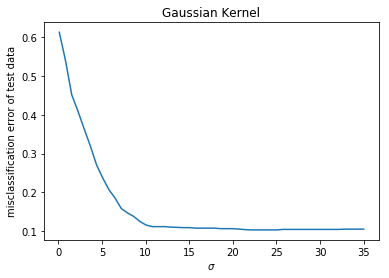

In [17]:
# Gaussian
Error_G = []
Sigma = np.linspace(0.1, 35, 50)
for sigma in Sigma:    
    kernel.setKernel('Gaussian', sigma)
    clf.train( data_train, label_train, kernel )
    Error_G.append( clf.test_error(data_test, label_test) )

plt.plot( Sigma, Error_G )
plt.xlabel(r'$\sigma$')
plt.ylabel('misclassification error of test data')
plt.title('Gaussian Kernel')
plt.show()

## Vovk Kernel
The best performance happens when p = 2, where the error is about 0.105.

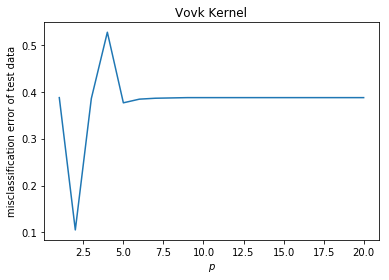

In [18]:
# Vovk
Error_V = []
P = np.linspace(1,20,20)
for p in P:    
    kernel.setKernel('Vovk', p)
    clf.train( data_train, label_train, kernel )
    Error_V.append( clf.test_error(data_test, label_test) )

plt.plot( P, Error_V )
plt.xlabel(r'$p$')
plt.ylabel('misclassification error of test data')
plt.title('Vovk Kernel')
plt.show()